# Stehekin 2025 Debris Flows

This notebook explores the recent debris flows reported and detected at UW.DREAM

In [1]:
# Import required libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from datetime import timezone
import pytz
import matplotlib.dates as mdates

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

# For interactive plots in Jupyter
%matplotlib inline

print("✓ Imports successful!")

✓ Imports successful!


## 1. Configuration

In [2]:
# Calculate time window
endtime = UTCDateTime.now()
starttime = UTCDateTime("2025-12-01T00:00:00") 

print(f"UW.DREAM Mudslide Detection")
print(f"Time window: {starttime} to {endtime}")
print(f"Duration: {(endtime - starttime) / 3600:.1f} hours")


UW.DREAM Mudslide Detection
Time window: 2025-12-01T00:00:00.000000Z to 2025-12-15T20:04:21.378391Z
Duration: 356.1 hours


## 2. Download Data from IRIS

In [3]:
# Download waveform data
print(f"Downloading data for UW.DREAM...")
client = Client("IRIS")

try:
    stream = client.get_waveforms(
        network="UW",
        station="DREAM",
        channel="HH*",
        location="*",
        starttime=starttime,
        endtime=endtime
    )
    
    # Merge traces and fill gaps
    stream.merge(method=1, fill_value=0)
    
    # high pass above 1 Hz
    stream.filter("highpass", freq=1.0)
    # downsample to 50 Hz
    stream.decimate(factor=int(stream[0].stats.sampling_rate / 50), no_filter=True)

    print(f"✓ Downloaded {len(stream)} traces")
    print(f"\nStream info:")
    print(stream)
    
    # Get station inventory for response removal
    print("\nFetching station inventory...")
    inventory = client.get_stations(
        network="UW",
        station="DREAM",
        channel="HH*",
        location="*",
        starttime=starttime,
        endtime=endtime,
        level="response"
    )
    print("✓ Inventory retrieved")
    
except Exception as e:
    print(f"✗ Error downloading data: {e}")
    raise

✓ Downloaded 3 traces

Stream info:
3 Trace(s) in Stream:
UW.DREAM..HHE | 2025-12-01T00:00:00.000000Z - 2025-12-15T20:04:17.400000Z | 50.0 Hz, 64092871 samples
UW.DREAM..HHN | 2025-12-01T00:00:00.000000Z - 2025-12-15T20:04:16.300000Z | 50.0 Hz, 64092816 samples
UW.DREAM..HHZ | 2025-12-01T00:00:00.000000Z - 2025-12-15T20:04:16.020000Z | 50.0 Hz, 64092802 samples

Fetching station inventory...
✓ Inventory retrieved
✓ Downloaded 3 traces

Stream info:
3 Trace(s) in Stream:
UW.DREAM..HHE | 2025-12-01T00:00:00.000000Z - 2025-12-15T20:04:17.400000Z | 50.0 Hz, 64092871 samples
UW.DREAM..HHN | 2025-12-01T00:00:00.000000Z - 2025-12-15T20:04:16.300000Z | 50.0 Hz, 64092816 samples
UW.DREAM..HHZ | 2025-12-01T00:00:00.000000Z - 2025-12-15T20:04:16.020000Z | 50.0 Hz, 64092802 samples

Fetching station inventory...
✓ Inventory retrieved


## 3. Data Preprocessing and Visualization

Creating daily plots for 16 days...
  ✓ Saved 2025-11-30
  ✓ Saved 2025-11-30


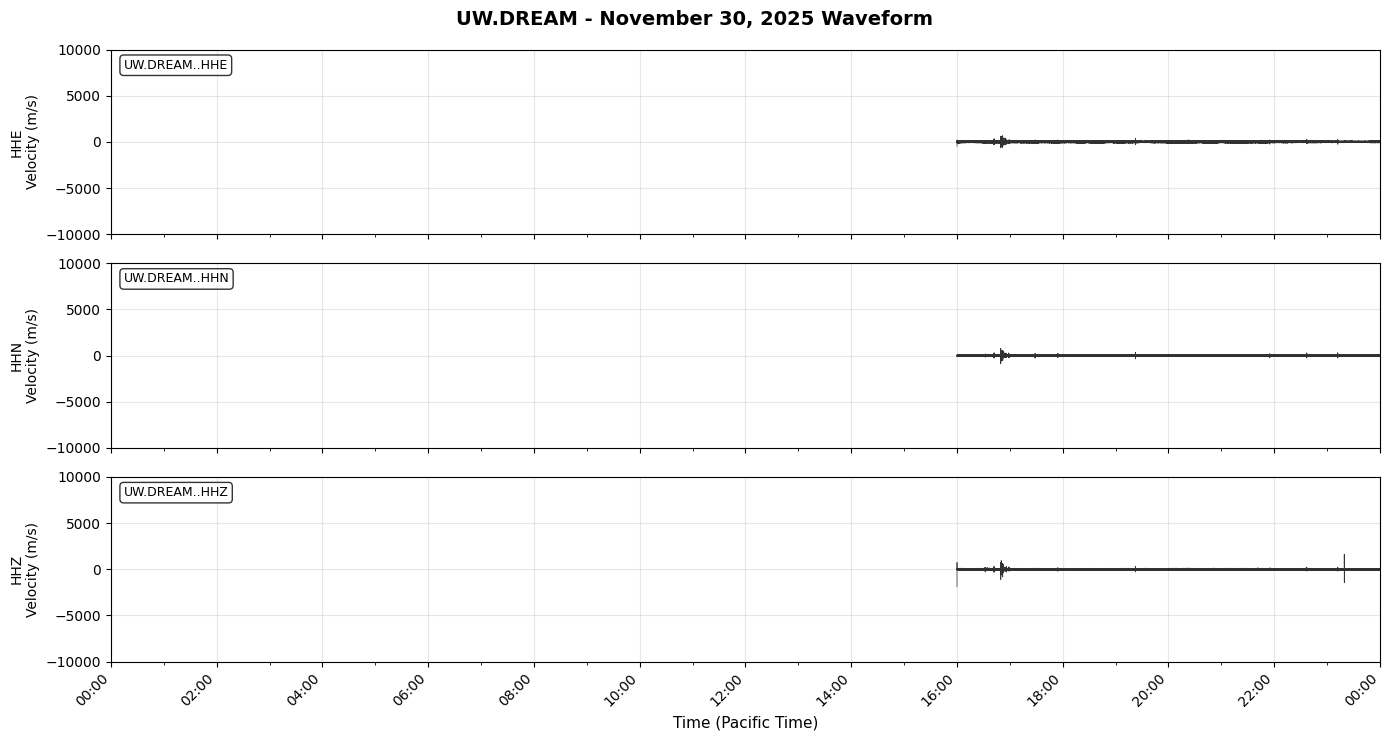

  ✓ Saved 2025-12-01


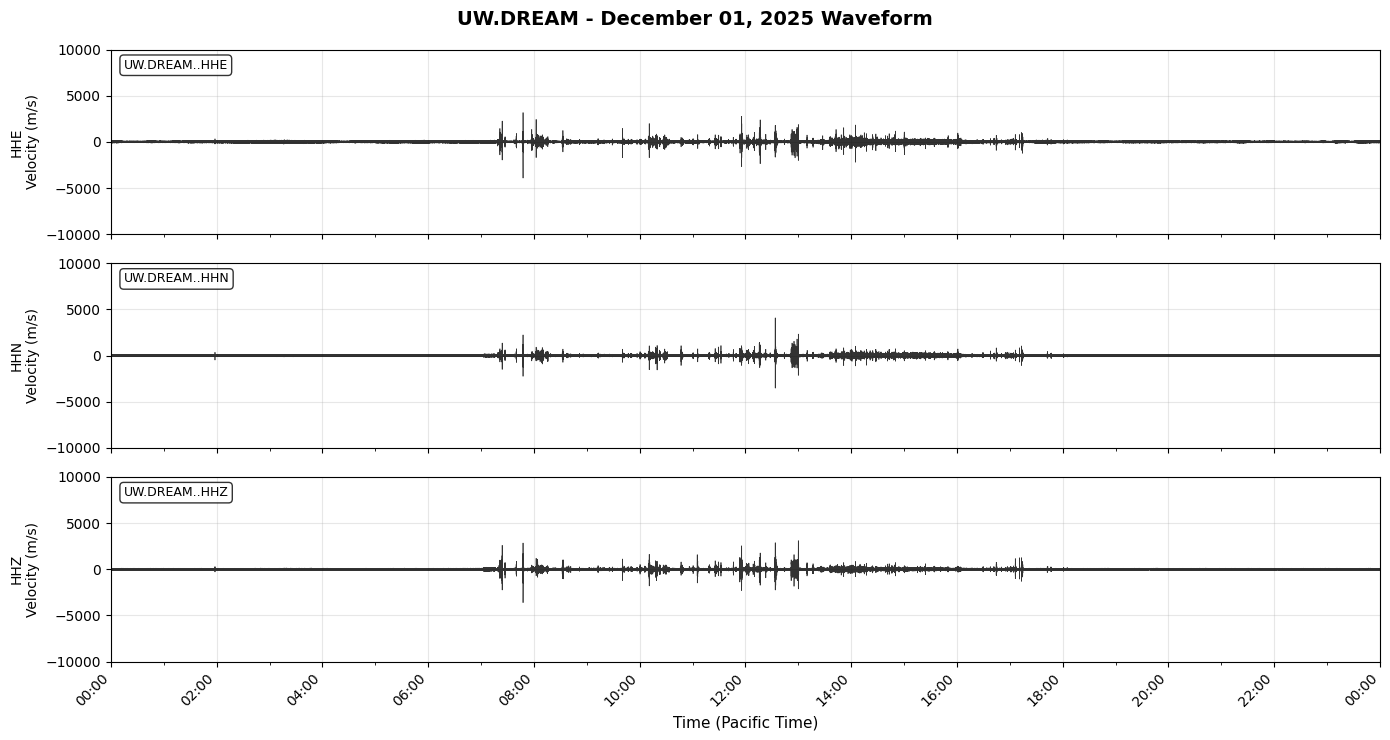

  ✓ Saved 2025-12-02


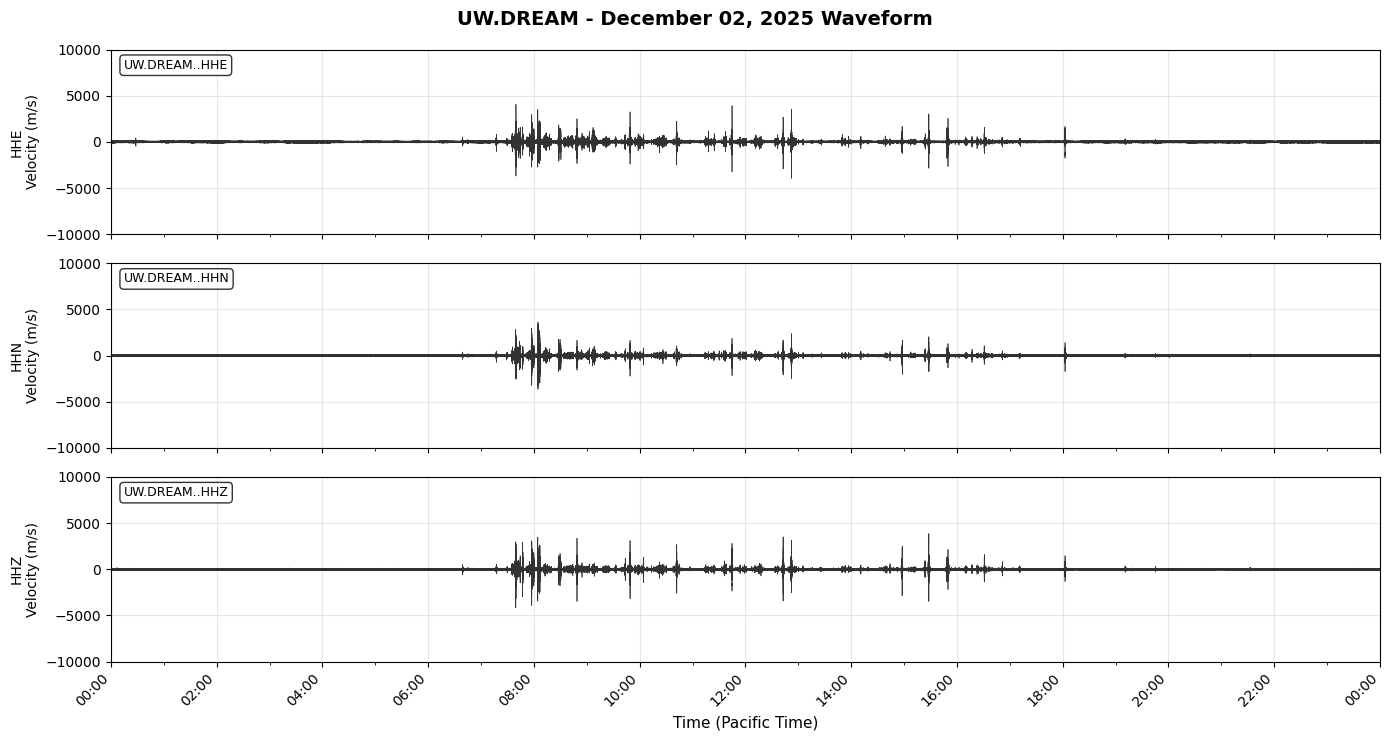

  ✓ Saved 2025-12-03


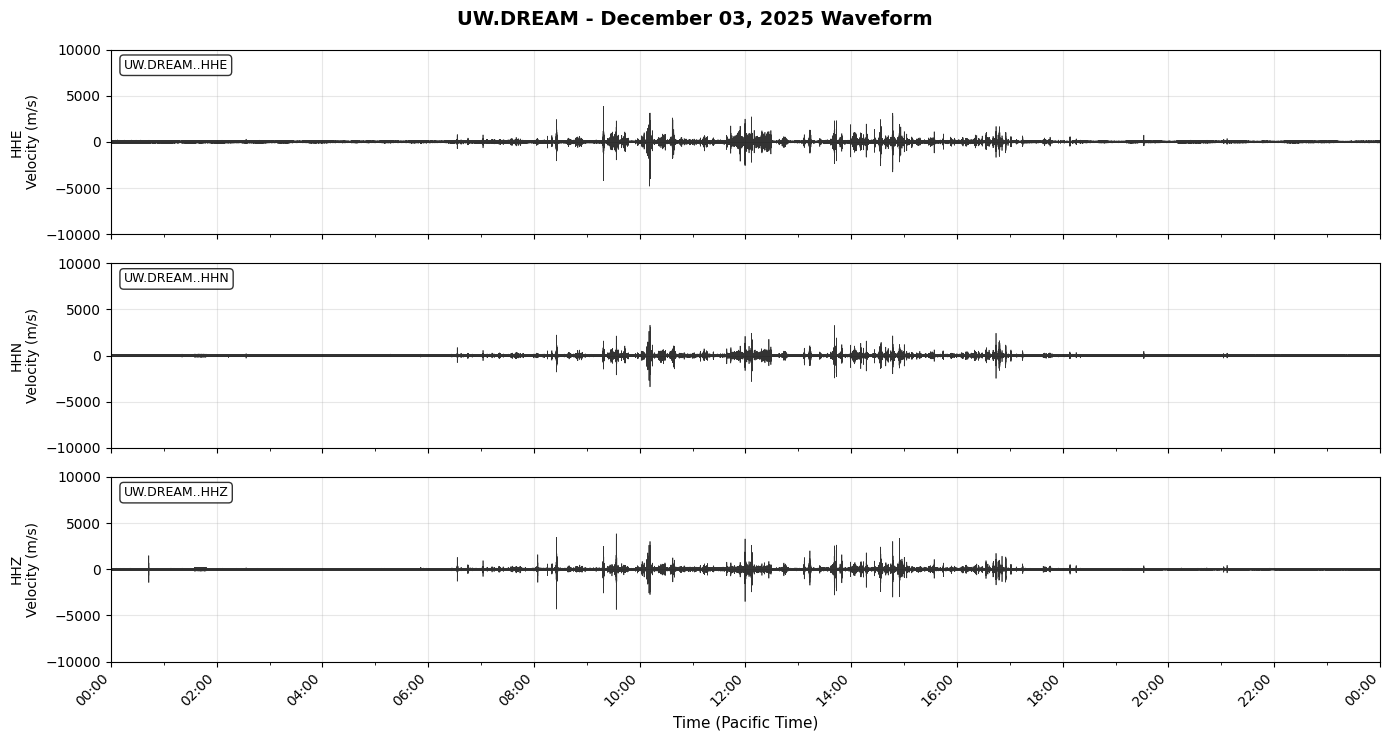

  ✓ Saved 2025-12-04


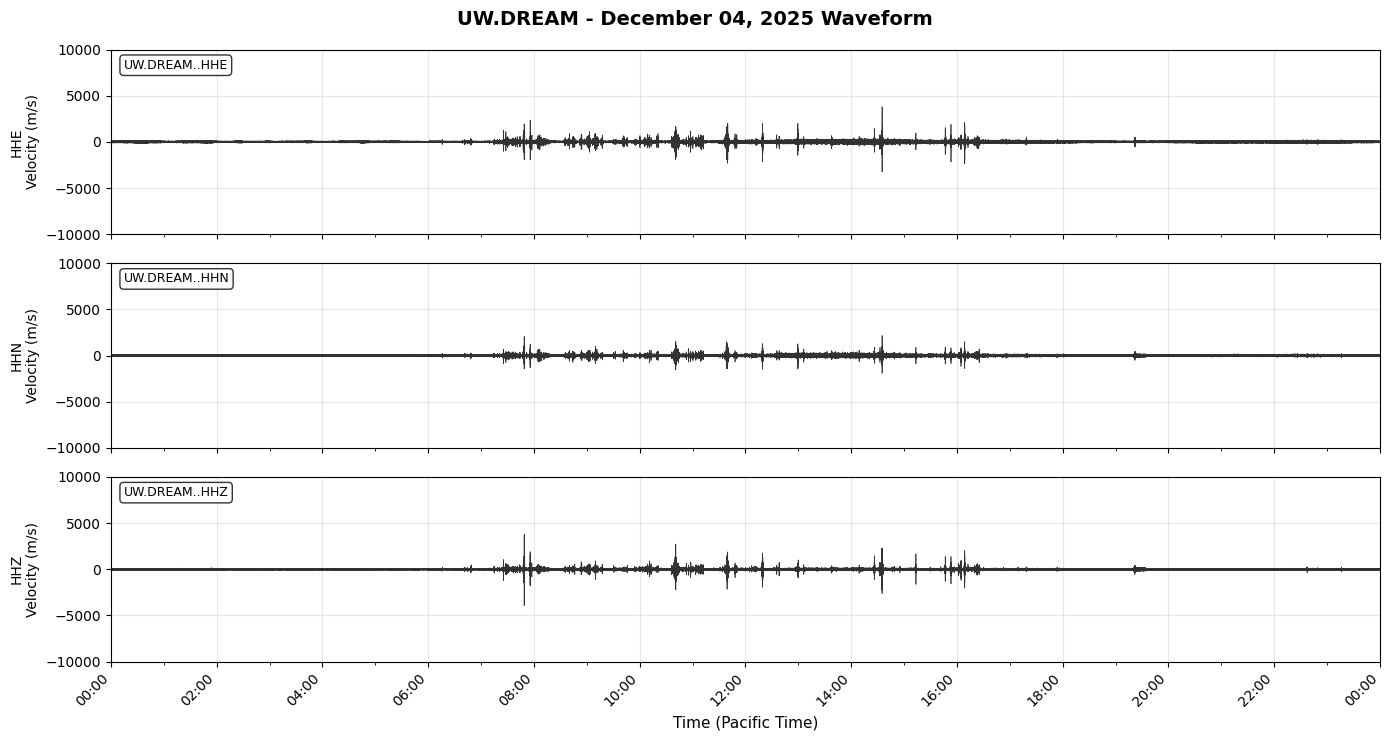

  ✓ Saved 2025-12-05


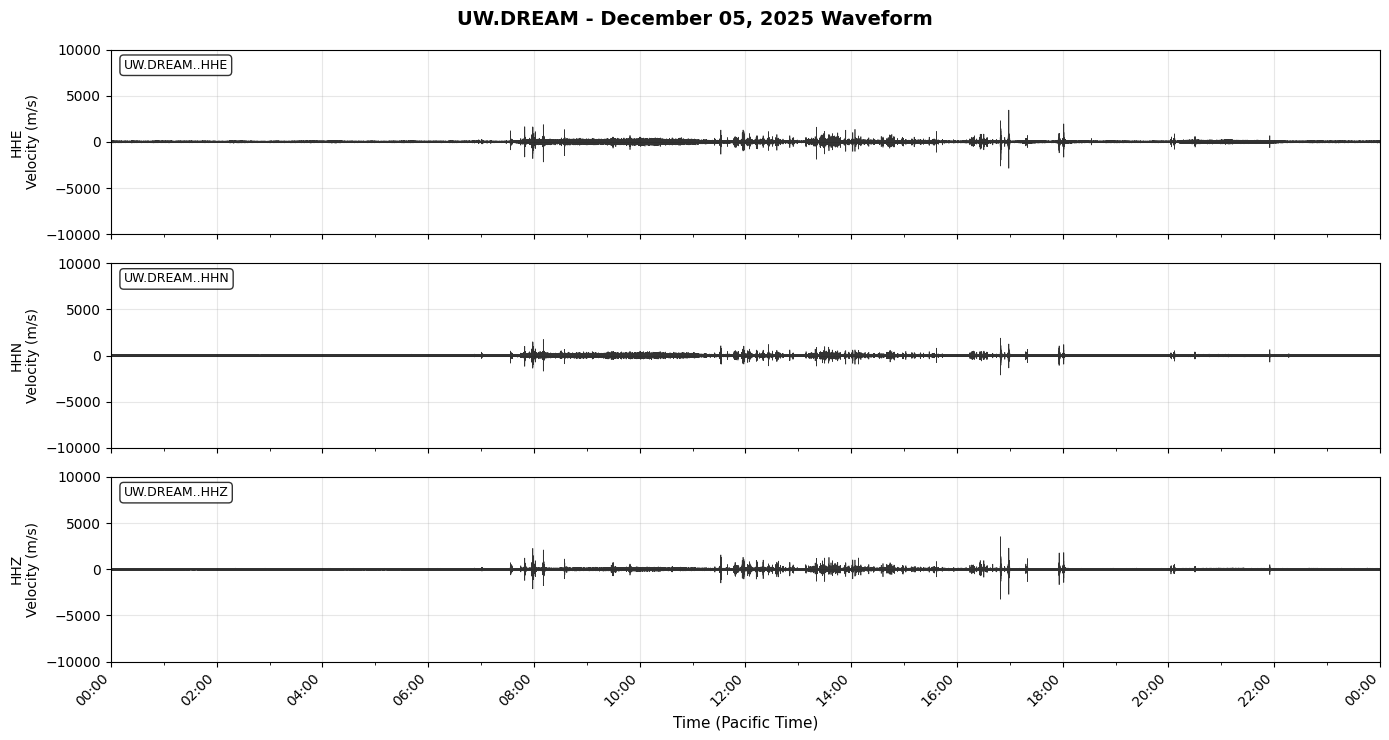

  ✓ Saved 2025-12-06


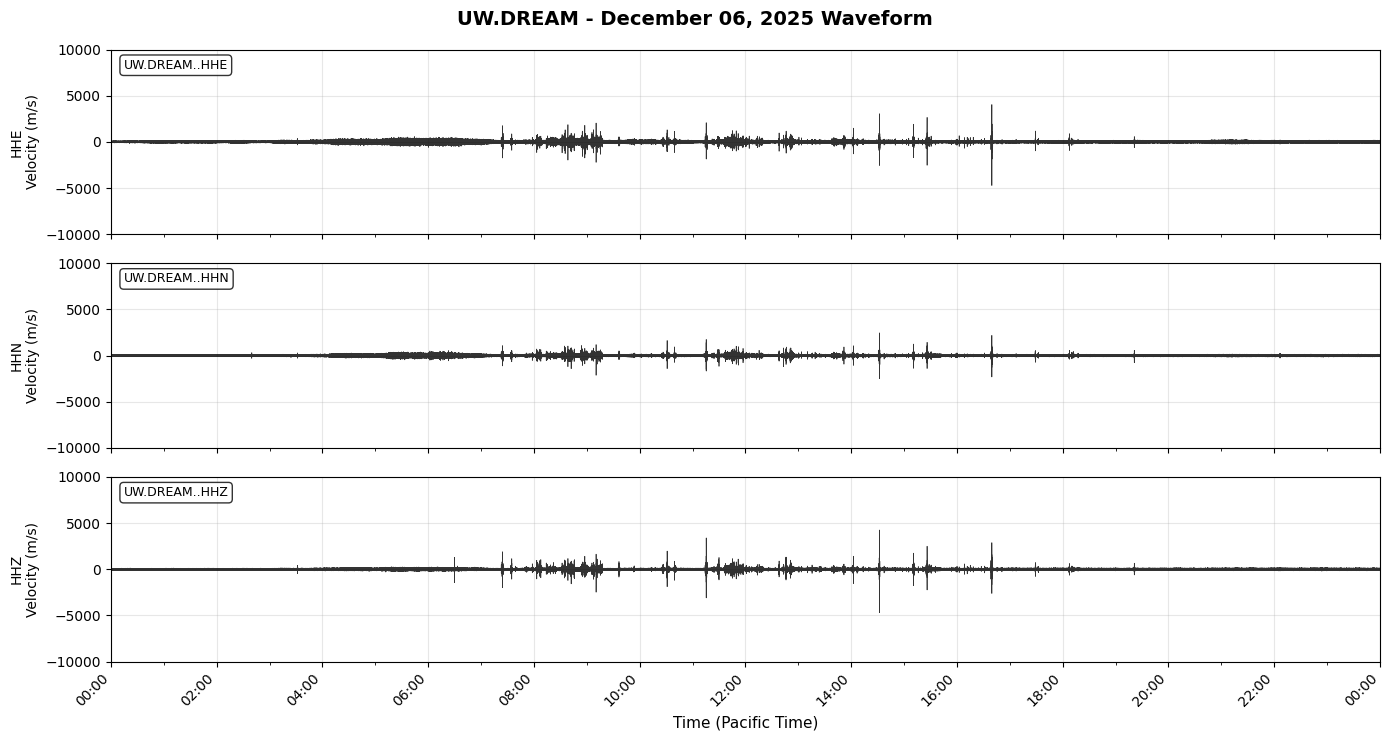

  ✓ Saved 2025-12-07


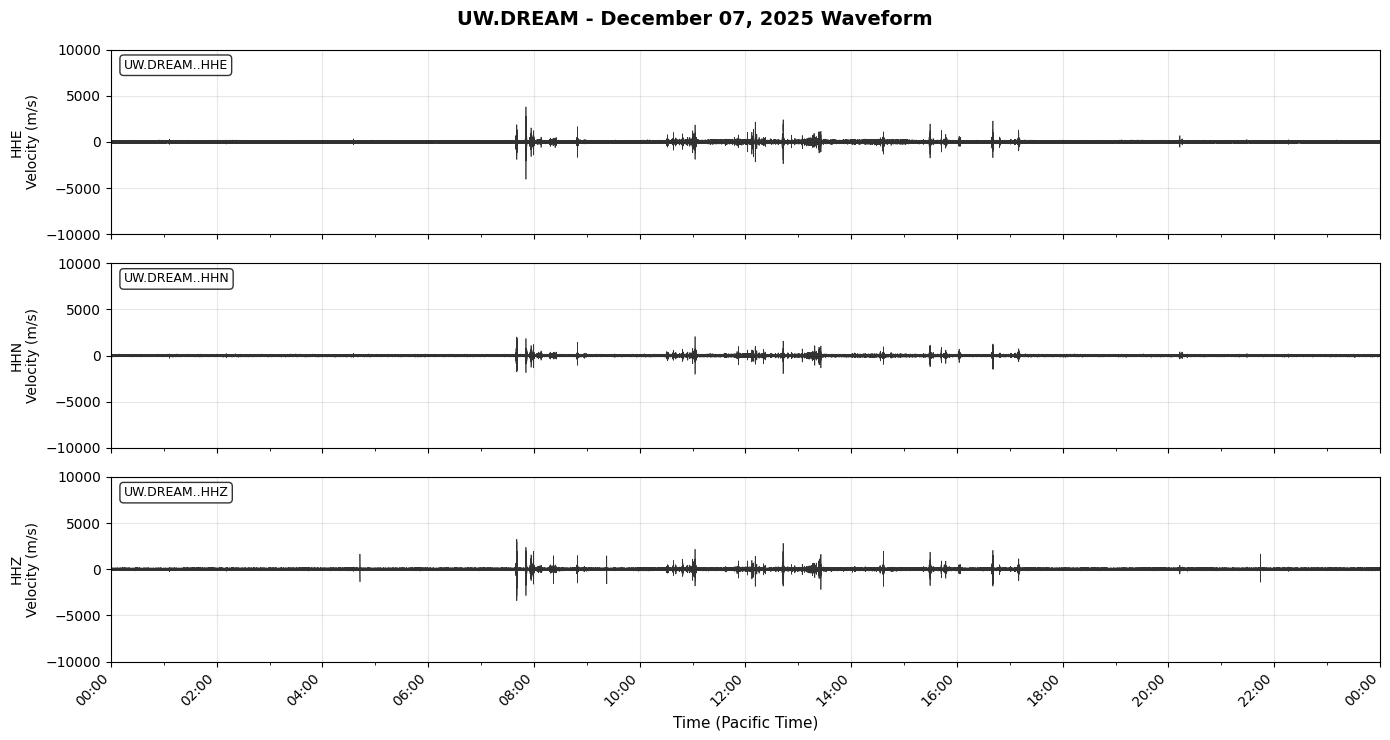

  ✓ Saved 2025-12-08


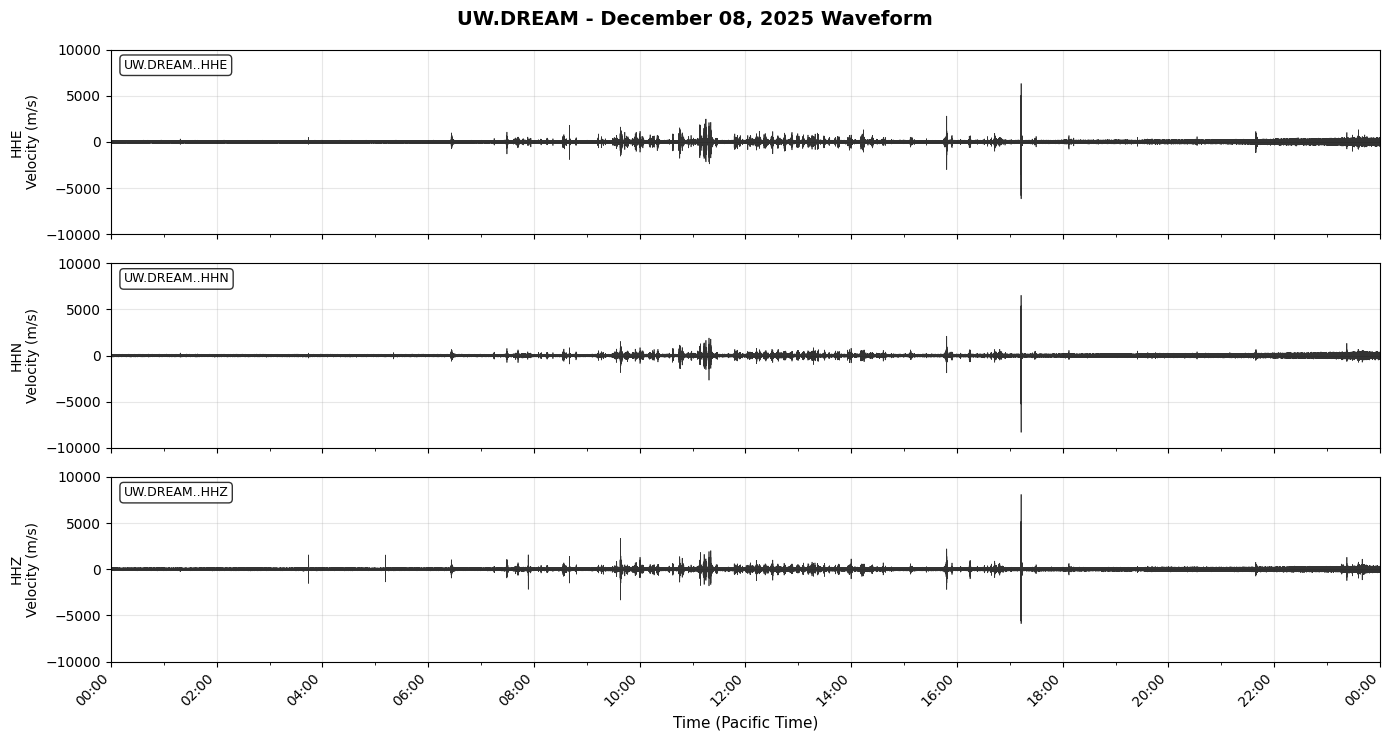

  ✓ Saved 2025-12-09


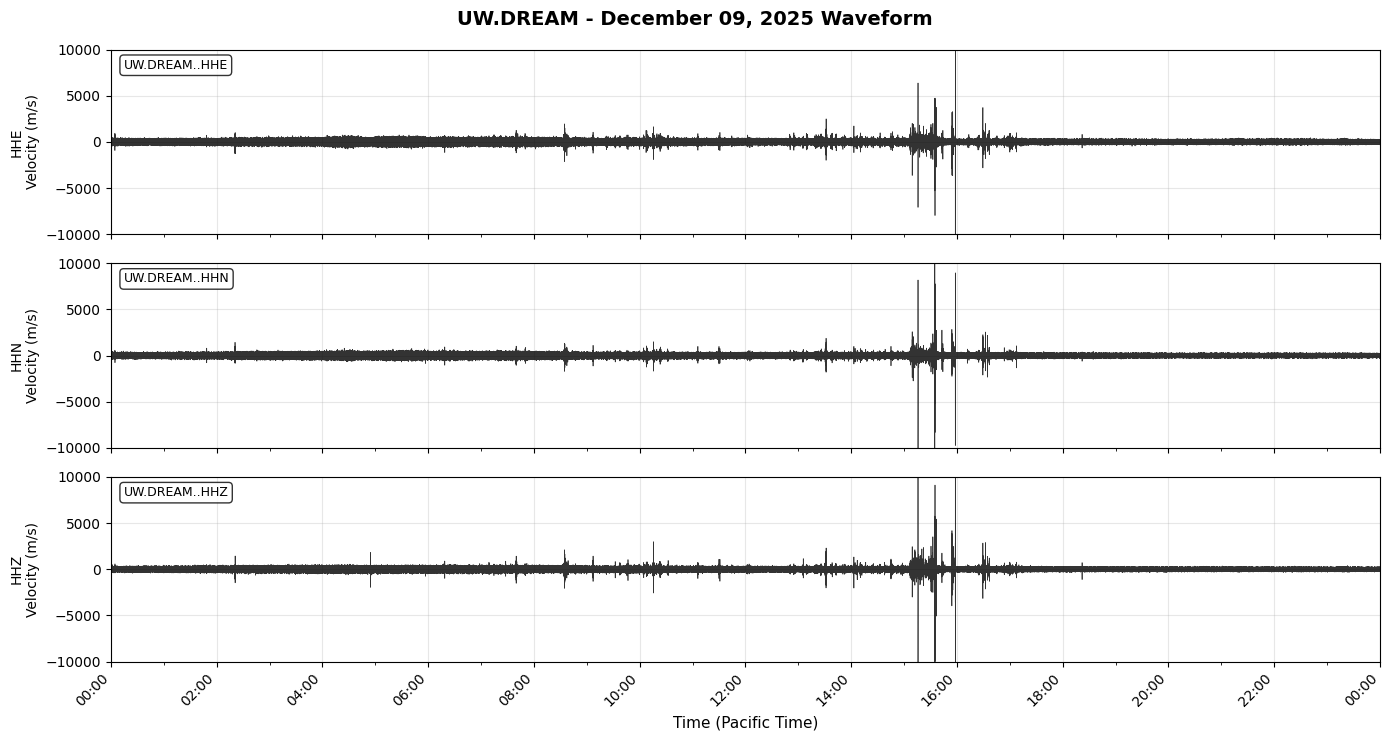

  ✓ Saved 2025-12-10


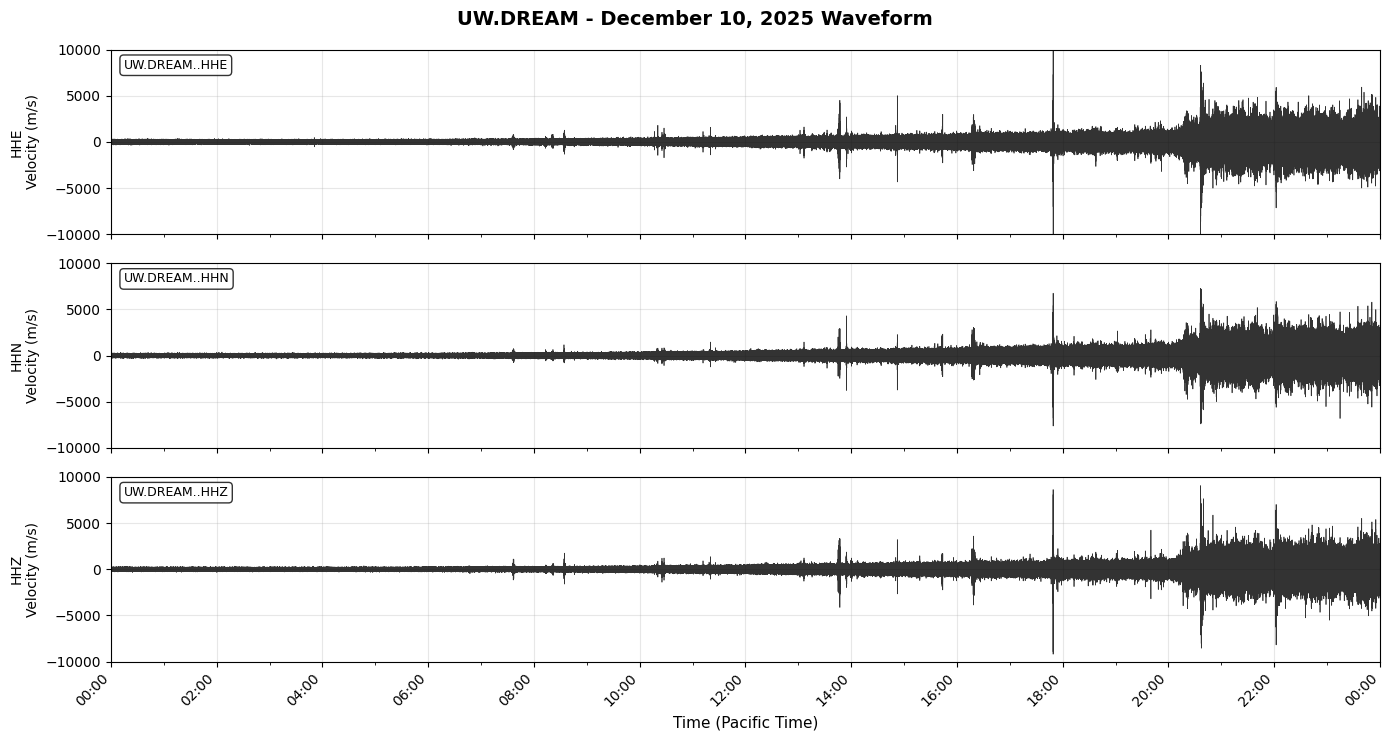

  ✓ Saved 2025-12-11


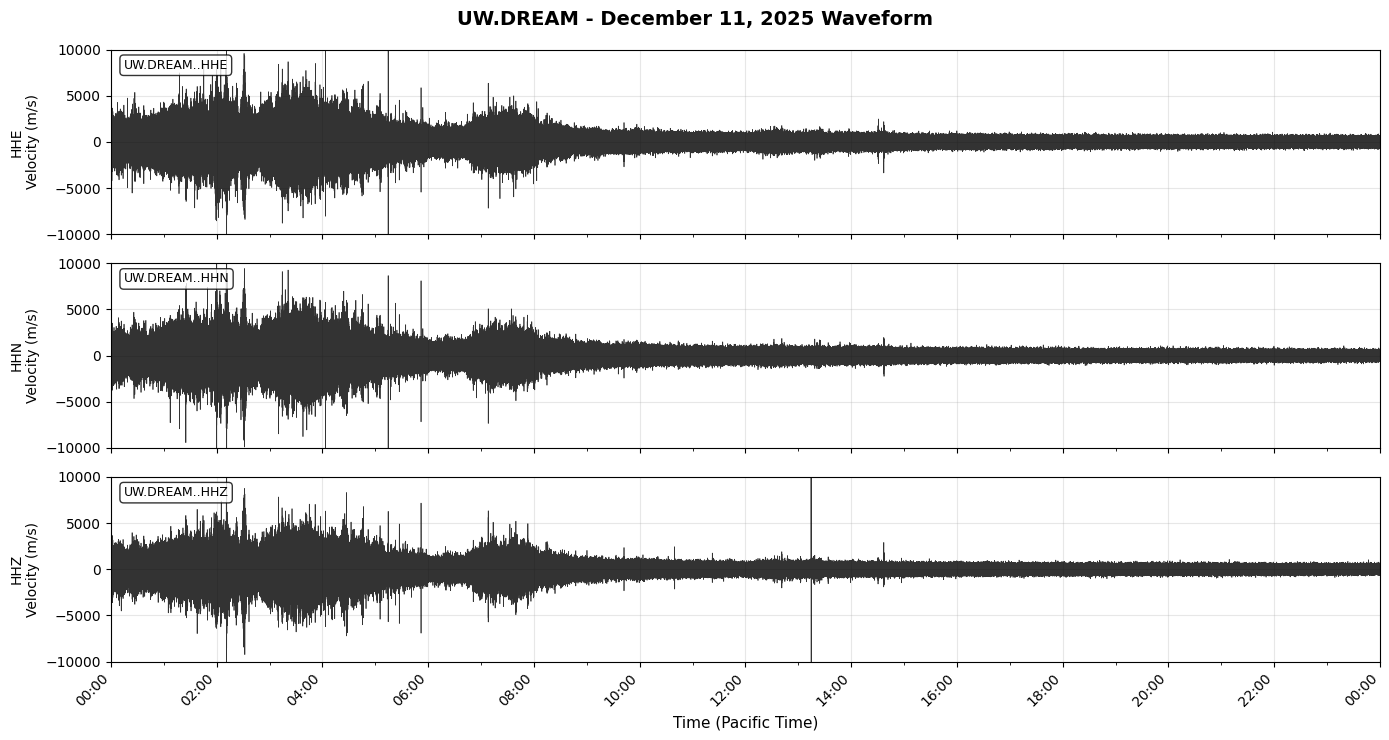

  ✓ Saved 2025-12-12


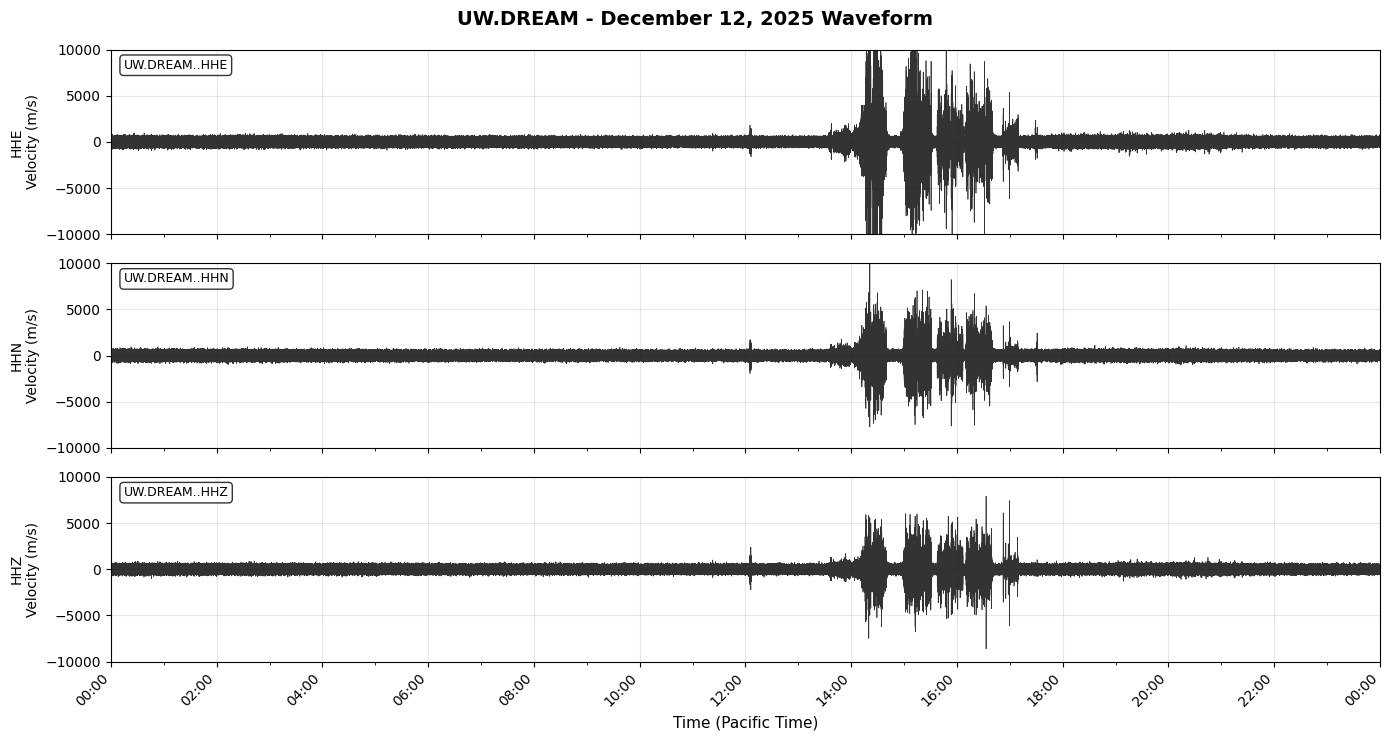

  ✓ Saved 2025-12-13


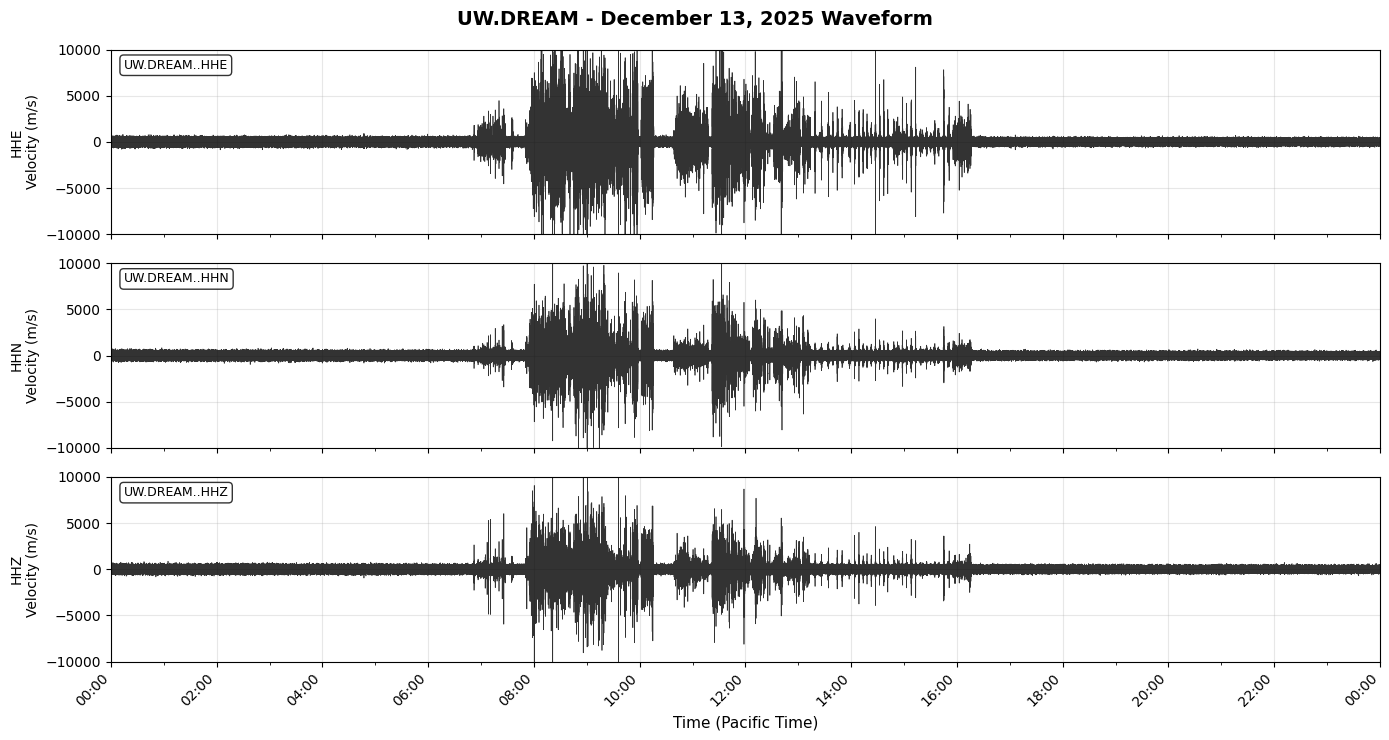

  ✓ Saved 2025-12-14


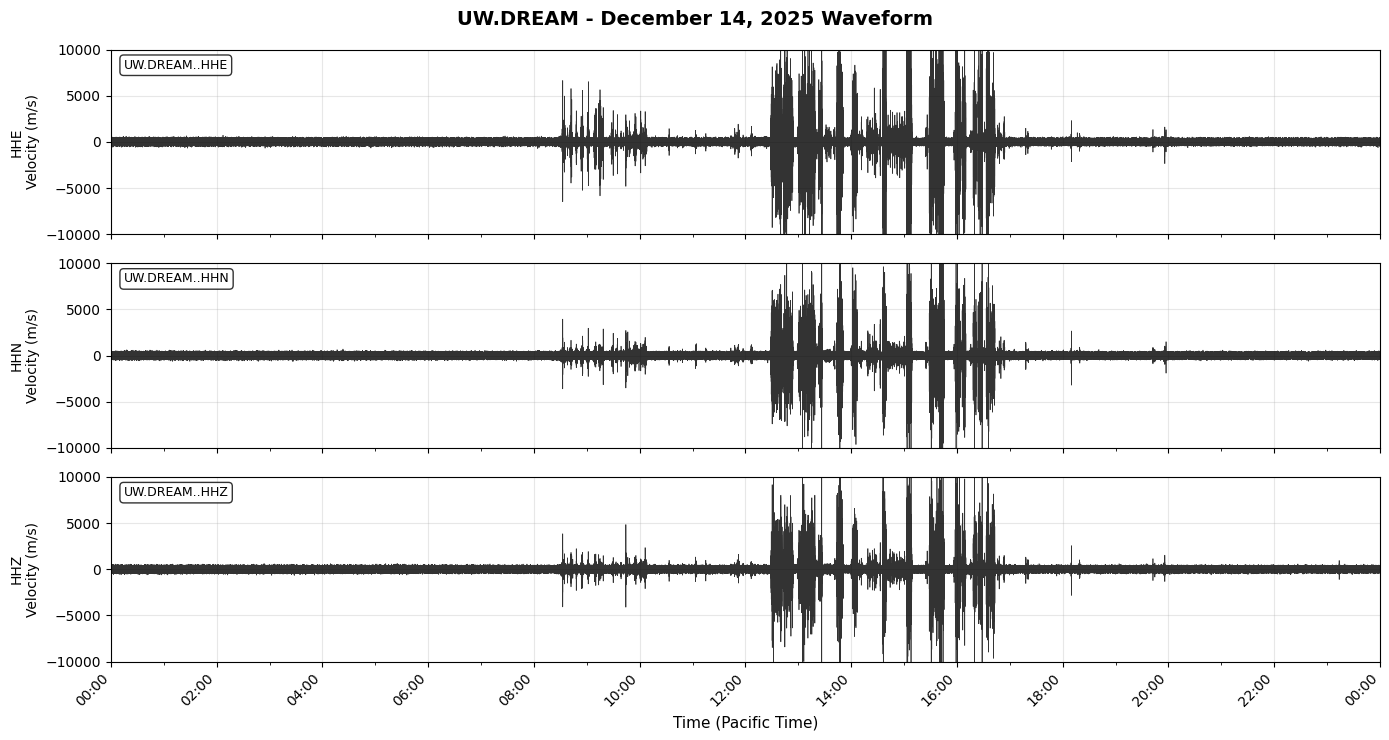

  ✓ Saved 2025-12-15


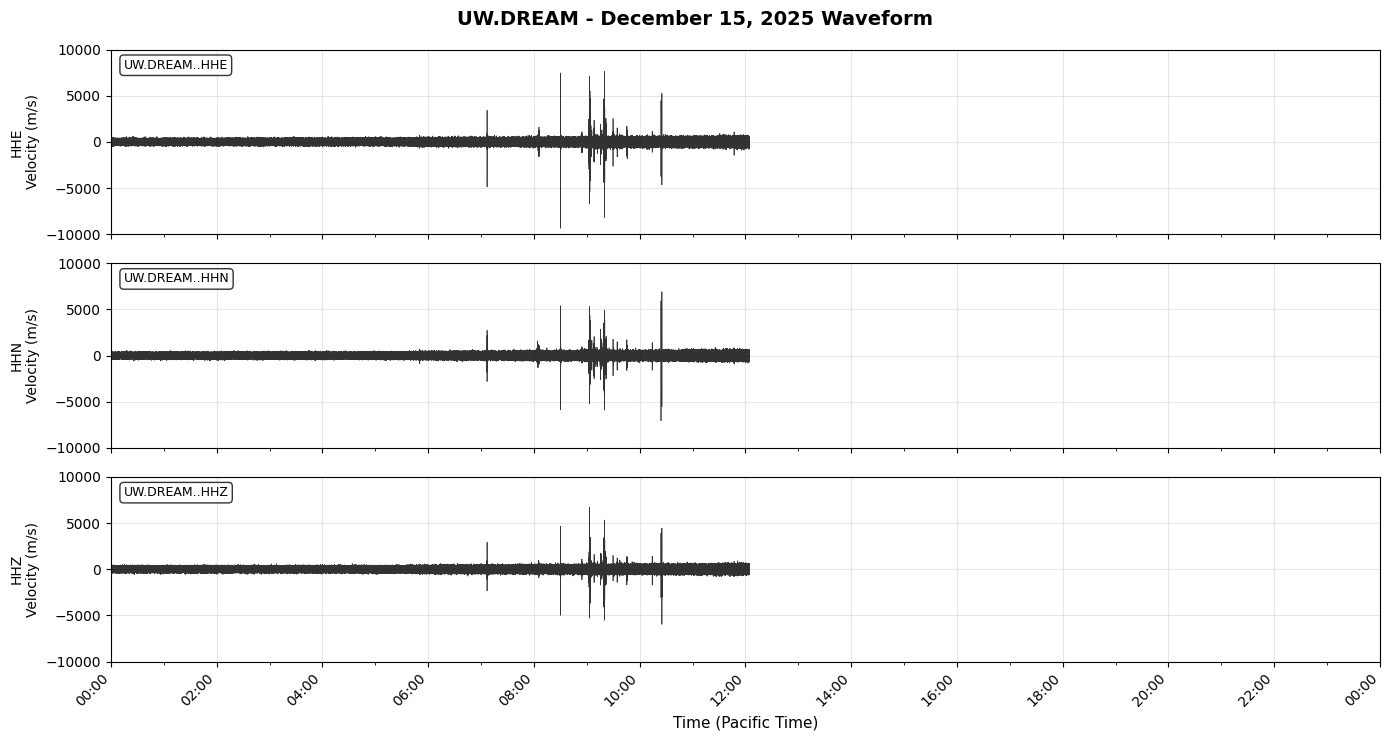


✓ All daily plots completed!


In [4]:
# Create time array for plotting
local_tz = pytz.timezone('America/Los_Angeles')  # Pacific Time for Washington State

# Convert stream times to local timezone
start_local = starttime.datetime.replace(tzinfo=timezone.utc).astimezone(local_tz)
end_local = endtime.datetime.replace(tzinfo=timezone.utc).astimezone(local_tz)

# Generate list of days to plot
current_day = start_local.date()
end_day = end_local.date()
plot_days = []

while current_day <= end_day:
    plot_days.append(current_day)
    current_day += pd.Timedelta(days=1)

print(f"Creating daily plots for {len(plot_days)} days...")

# Create plots for each day
for day in plot_days:
    # Define day boundaries in local time
    day_start_local = local_tz.localize(pd.Timestamp(day))
    day_end_local = day_start_local + pd.Timedelta(days=1)
    
    # Convert to UTC for slicing
    day_start_utc = day_start_local.astimezone(timezone.utc)
    day_end_utc = day_end_local.astimezone(timezone.utc)
    
    # Slice stream for this day
    stream_day = stream.copy()
    stream_day = stream_day.slice(
        starttime=UTCDateTime(day_start_utc),
        endtime=UTCDateTime(day_end_utc)
    )
    
    if len(stream_day) == 0:
        print(f"  No data for {day}")
        continue
    
    # Create figure for this day
    fig, axes = plt.subplots(len(stream_day), 1, figsize=(14, 2.5 * len(stream_day)), sharex=True)
    if len(stream_day) == 1:
        axes = [axes]
    
    for i, tr in enumerate(stream_day):
        # Create datetime array for x-axis
        times_utc = [tr.stats.starttime.datetime + pd.Timedelta(seconds=t) for t in tr.times()]
        times_local = [t.replace(tzinfo=timezone.utc).astimezone(local_tz) for t in times_utc]
        
        # Plot
        axes[i].plot(times_local, tr.data, 'k-', linewidth=0.5, alpha=0.8)
        axes[i].set_ylabel(f'{tr.stats.channel}\nVelocity (m/s)', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(-1E4, 1E4)
        axes[i].text(0.01, 0.95, f'{tr.stats.network}.{tr.stats.station}.{tr.stats.location}.{tr.stats.channel}',
                    transform=axes[i].transAxes, fontsize=9, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Format x-axis to show hours
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=local_tz))
    axes[-1].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[-1].xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    axes[-1].set_xlabel(f'Time (Pacific Time)', fontsize=11)
    
    # Set x-axis limits to full day
    axes[-1].set_xlim(day_start_local, day_end_local)
    
    fig.suptitle(f'UW.DREAM - {day.strftime("%B %d, %Y")} Waveform', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    save_path = f"../plots/DREAM_{day.strftime('%Y-%m-%d')}_waveforms.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"  ✓ Saved {day}")
    
    plt.show()

print(f"\n✓ All daily plots completed!")

In [ ]:
## 4. Download Weather Data from HRRR Model

We'll use the High-Resolution Rapid Refresh (HRRR) model to get precipitation and temperature data for the DREAM station location.

In [5]:
# Get DREAM station coordinates
station_lat = inventory[0][0].latitude
station_lon = inventory[0][0].longitude
station_elev = inventory[0][0].elevation

print(f"UW.DREAM Station Location:")
print(f"  Latitude: {station_lat:.4f}°")
print(f"  Longitude: {station_lon:.4f}°")
print(f"  Elevation: {station_elev:.1f} m")

# Install herbie-data if needed (uncomment to install)
# !pip install herbie-data

UW.DREAM Station Location:
  Latitude: 48.3090°
  Longitude: -120.6549°
  Elevation: 370.5 m


In [6]:
# Import Herbie for HRRR data access
try:
    from herbie import Herbie
    print("✓ Herbie imported successfully")
except ImportError:
    print("Installing herbie-data...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "herbie-data"])
    from herbie import Herbie
    print("✓ Herbie installed and imported")

from datetime import datetime, timedelta

Installing herbie-data...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/11.6 MB ? eta -:--:--Downloading herbie_data-2025.12.0-py3-none-any.whl (117 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
noisepy-seis 0.9.87.dev1 requires pandas<2.0.0,>=1.5.3, but you have pandas 2.3.3 which is incompatible.
noisepy-seis-io 0.1.14 requires pandas<2.0.0,>=1.5.3, but you have pandas 2.3.3 which is incompatible.


 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ INFO: Created a default config file.                 │
 │ You may view/edit Herbie's configuration here:       │
 │  /Users/marinedenolle/.config/herbie/config.toml     │
 ╰──────────────────────────────────────────────────────╯

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ INFO: Created a default config file.                 │
 │ You may view/edit Herbie's configuration here:       │
 │  /Users/marinedenolle/.config/herbie/config.toml     │
 ╰──────────────────────────────────────────────────────╯



AttributeError: module 'pandas.arrays' has no attribute 'NumpyExtensionArray'

In [ ]:
# Download HRRR data for the time period
print("Downloading HRRR weather data...")
print(f"Date range: {starttime.datetime.date()} to {endtime.datetime.date()}")

# Variables to download
variables = [
    'APCP',  # Total precipitation
    'TMP',   # Temperature
    'UGRD',  # U-component of wind
    'VGRD',  # V-component of wind
]

# Initialize lists to store data
weather_data = {
    'time': [],
    'precipitation': [],
    'temperature': [],
    'wind_u': [],
    'wind_v': [],
}

# Download hourly data
current_time = starttime.datetime
end_datetime = endtime.datetime

print(f"Fetching data for location: {station_lat:.4f}°N, {station_lon:.4f}°W")

while current_time <= end_datetime:
    try:
        # Create Herbie object for this time
        H = Herbie(
            current_time,
            model='hrrr',
            product='sfc',  # Surface level
            fxx=0  # Analysis (0-hour forecast)
        )
        
        # Download and extract data for the station location
        # APCP - Accumulated precipitation
        ds_precip = H.xarray('APCP:surface', remove_grib=False)
        precip_val = ds_precip.sel(
            latitude=station_lat, 
            longitude=station_lon, 
            method='nearest'
        )['APCP'].values
        
        # TMP - Temperature at 2m
        ds_temp = H.xarray('TMP:2 m', remove_grib=False)
        temp_val = ds_temp.sel(
            latitude=station_lat, 
            longitude=station_lon, 
            method='nearest'
        )['t2m'].values
        
        # Wind components at 10m
        ds_wind_u = H.xarray('UGRD:10 m', remove_grib=False)
        wind_u_val = ds_wind_u.sel(
            latitude=station_lat, 
            longitude=station_lon, 
            method='nearest'
        )['u10'].values
        
        ds_wind_v = H.xarray('VGRD:10 m', remove_grib=False)
        wind_v_val = ds_wind_v.sel(
            latitude=station_lat, 
            longitude=station_lon, 
            method='nearest'
        )['v10'].values
        
        # Store data
        weather_data['time'].append(current_time)
        weather_data['precipitation'].append(float(precip_val))
        weather_data['temperature'].append(float(temp_val) - 273.15)  # Convert K to C
        weather_data['wind_u'].append(float(wind_u_val))
        weather_data['wind_v'].append(float(wind_v_val))
        
        if current_time.hour == 0:
            print(f"  Downloaded: {current_time.date()}")
            
    except Exception as e:
        print(f"  Warning: Could not download data for {current_time}: {e}")
        weather_data['time'].append(current_time)
        weather_data['precipitation'].append(np.nan)
        weather_data['temperature'].append(np.nan)
        weather_data['wind_u'].append(np.nan)
        weather_data['wind_v'].append(np.nan)
    
    # Move to next hour
    current_time += timedelta(hours=1)

# Create DataFrame
weather_df = pd.DataFrame(weather_data)

# Calculate wind speed
weather_df['wind_speed'] = np.sqrt(weather_df['wind_u']**2 + weather_df['wind_v']**2)

# Calculate cumulative precipitation
weather_df['cumulative_precip'] = weather_df['precipitation'].cumsum()

print(f"\n✓ Downloaded {len(weather_df)} hours of weather data")
print(f"\nWeather data summary:")
print(weather_df.describe())

In [ ]:
# Plot weather data
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# Convert times to local timezone
weather_df['time_local'] = pd.to_datetime(weather_df['time']).dt.tz_localize('UTC').dt.tz_convert(local_tz)

# Plot 1: Precipitation
axes[0].bar(weather_df['time_local'], weather_df['precipitation'], 
           width=0.04, color='blue', alpha=0.6, label='Hourly')
axes[0].plot(weather_df['time_local'], weather_df['cumulative_precip'], 
            'b-', linewidth=2, label='Cumulative')
axes[0].set_ylabel('Precipitation (mm)', fontsize=11)
axes[0].set_title('HRRR Weather Data for UW.DREAM Location', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper left')

# Plot 2: Temperature
axes[1].plot(weather_df['time_local'], weather_df['temperature'], 
            'r-', linewidth=1.5, alpha=0.8)
axes[1].fill_between(weather_df['time_local'], weather_df['temperature'], 
                     0, alpha=0.2, color='red')
axes[1].axhline(y=0, color='blue', linestyle='--', alpha=0.5, linewidth=1)
axes[1].set_ylabel('Temperature (°C)', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Plot 3: Wind Speed
axes[2].plot(weather_df['time_local'], weather_df['wind_speed'], 
            'g-', linewidth=1.5, alpha=0.8)
axes[2].fill_between(weather_df['time_local'], weather_df['wind_speed'], 
                     0, alpha=0.2, color='green')
axes[2].set_ylabel('Wind Speed (m/s)', fontsize=11)
axes[2].set_xlabel('Time (Pacific Time)', fontsize=11)
axes[2].grid(True, alpha=0.3)

# Format x-axis
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d', tz=local_tz))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
    
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()

weather_path = f"../plots/DREAM_{starttime.date}_weather.png"
plt.savefig(weather_path, dpi=150, bbox_inches='tight')
print(f"✓ Weather plot saved to {weather_path}")

plt.show()

In [ ]:
# Save weather data to CSV
weather_csv = f"../data/processed/DREAM_{starttime.date}_weather.csv"
weather_df.to_csv(weather_csv, index=False)
print(f"✓ Weather data saved to {weather_csv}")

# Display key statistics
print(f"\nKey Weather Statistics ({starttime.date} to {endtime.date}):")
print(f"  Total Precipitation: {weather_df['cumulative_precip'].iloc[-1]:.2f} mm")
print(f"  Mean Temperature: {weather_df['temperature'].mean():.1f}°C")
print(f"  Min Temperature: {weather_df['temperature'].min():.1f}°C")
print(f"  Max Temperature: {weather_df['temperature'].max():.1f}°C")
print(f"  Mean Wind Speed: {weather_df['wind_speed'].mean():.1f} m/s")
print(f"  Max Wind Speed: {weather_df['wind_speed'].max():.1f} m/s")